In [1]:
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skfmm

import lib.imageutl as imutl
import lib.visualizationutl as view

import unet.unet as nt
import unet.util as ntutl

#plt.rcParams['image.cmap'] = 'gist_earth'
%matplotlib inline


In [2]:
pathdataset = '../db'
namedataset = 'car'
metadata = 'metadata.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

print(pathname)
print(pathmetadata)

../db/car
../db/car/metadata.csv


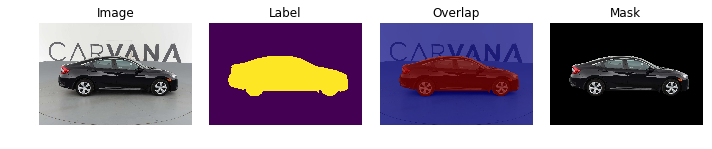

(1280, 1918, 3)


In [4]:
data_provider = imutl.procProvide( pathname, fn_image='train', fn_label='train_masks', lext='gif')
view.display_image_and_gt( data_provider )
print(data_provider.getimage(0).shape)


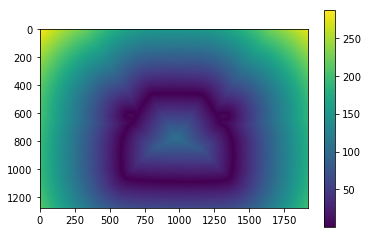

0.117851130198
286.746291105


In [244]:
import skfmm
import scipy.ndimage as ndimage

#weight map
def getweightmap(label):
    
    assert label.size > 0
    frac0 = np.sum(label == 0) / float(label.size)
    frac1 = np.sum(label == 1) / float(label.size)
    
    assert frac0 > 0
    assert frac1 > 0

    # Calculate
    w_c = np.empty(label.shape)
    w_c[label == 0] = 0.5 / (frac0)
    w_c[label == 1] = 0.5 / (frac1)
    
    return w_c


def curvature(p):
    '''
    Curvature 
    '''
    
    dx_dt = np.gradient(p[:, 0])
    dy_dt = np.gradient(p[:, 1])
    #velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])        
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
    #tangent = np.array([1/ds_dt] * 2).transpose() * velocity
    
    #d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5  
    curvature[-1] = 0
    return curvature; 
    

image  = data_provider.getimage(0)
label  = data_provider.getlabel()
weigth = getweightmap(  (label/255.0).astype( np.bool )  )

#label = (label/255.0).astype(np.uint8)
#c_mask = np.equal(label, 1)

# Find the signed distance from the zero contour
#distance = skfmm.distance(c_mask.astype('float32') - 0.5)
#d1_f = ndimage.distance_transform_edt(c_mask)
#d1_b = ndimage.distance_transform_edt(1 - c_mask)
#distance = np.maximum(d1_f, d1_b)

c_mask = (label).astype(np.uint8)
_,contours,_ = cv2.findContours(c_mask, cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE )

layer = np.zeros(label.shape, np.float32 )
layer_k = np.ones(label.shape, np.float32 )

plt.figure()
for cnt in contours: 
    #cv2.drawContours(c_mask, cnt, -1, 2, 1)
    
    p = cnt[::2,0,:]; 
    x = p[:,0]; y = p[:,1];
    k = curvature(p);     
    layer[y,x] = 1;
    layer_k[y,x] = k;
    

layer = skfmm.travel_time(layer - 0.5, speed = 3.0 * np.ones_like(layer))
#layer = skfmm.distance( layer - 0.5 )
plt.imshow(layer); plt.colorbar()
plt.show()
#plt.imsave('output.png',layer)

print( np.min(layer) )
print( np.max(layer) )

#plt.figure()
#plt.imshow(distance); plt.colorbar()
#plt.show()
#print( np.min(distance), np.max(distance)  ) 

#fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
#ax[0].imshow(image)
#ax[1].imshow(label)
#ax[2].imshow(weigth)
#plt.show()

#print( np.unique(weigth)  )
#plt.imshow(weigth); plt.colorbar()
#plt.show()



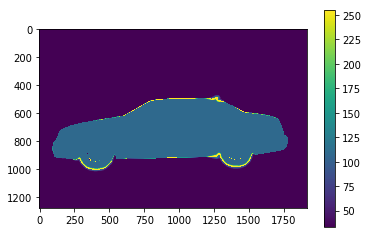

In [3]:

data_provider = imutl.procProvideEx( pathname, fn_image='train', fn_label='train_masks', lext='gif')
image  = data_provider.getimage( np.random.randint( data_provider.num ) )
label  = data_provider.getlabel()
weigth = data_provider.getweight()

plt.figure();
plt.imshow(weigth); plt.colorbar()
plt.show()


In [4]:
x_test, y_test, w_test = data_provider(2)

print(x_test.shape)
print(y_test.shape)
print(w_test.shape)
print(data_provider.channels, data_provider.n_class)
print(data_provider.channels)

(2, 572, 572, 3)
(2, 572, 572, 2)
(2, 572, 572, 1)
3 2
3


(572, 572, 3)


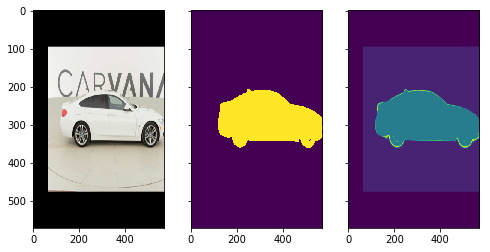

0.0 1.0
0.0 1.0
0.117647066712 3.0
(2, 572, 572, 3)
(2, 572, 572, 2)
(2, 572, 572, 1)


In [5]:
#fig, ax = plt.subplots(1,2, figsize=(8,4))
#ax[0].imshow(x_test[0,...,0])
#ax[1].imshow(y_test[0,...,1])
#plt.show()

im = x_test.transpose((1,2,3,0))
im = im[:,:,:,0];
print(im.shape)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(8,4))
ax[0].imshow(im, aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(w_test[0,...,0], aspect="auto")
plt.show()

print( np.min(x_test[0,...,0]), np.max(x_test[0,...,0])  )
print( np.min(y_test[0,...,1]), np.max(y_test[0,...,1])  )
print( np.min(w_test[0,...,0]), np.max(w_test[0,...,0])  )
print(x_test.shape)
print(y_test.shape)
print(w_test.shape)


In [6]:
import tensorflow as tf
print(tf.__version__)

1.3.0


In [7]:
net = nt.Unet(channels=data_provider.channels, 
              n_class=data_provider.n_class, 
              layers=3, 
              features_root=16,
              cost="cross_entropy",
              cost_kwargs=dict(class_weights=1.0, regularizer=0.001)
             )

2017-09-26 15:20:28,272 Layers 3, features 16, filter size 3x3, pool size: 2x2


Training Unet
---

In [8]:
#trainer = nt.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
trainer = nt.Trainer(net, optimizer="adam", opt_kwargs=dict(learning_rate=1e-4))

In [7]:
path = trainer.train(data_provider, "./unet_trained", training_iters=20, epochs=100, display_step=2)

2017-09-25 21:36:10,620 Removing '/home/pdmf/docker/caffe/car/python/prediction'
2017-09-25 21:36:10,622 Removing '/home/pdmf/docker/caffe/car/python/unet_trained'
2017-09-25 21:36:10,623 Allocating '/home/pdmf/docker/caffe/car/python/prediction'
2017-09-25 21:36:10,626 Allocating '/home/pdmf/docker/caffe/car/python/unet_trained'


ResourceExhaustedError: OOM when allocating tensor with shape[283024,283024]
	 [[Node: Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_34, Reshape_31)]]

Caused by op 'Mul', defined at:
  File "/home/pdmf/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pdmf/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2bf08e3690b9>", line 5, in <module>
    cost="cross_entropy"
  File "/home/pdmf/docker/caffe/car/python/unet/unet.py", line 191, in __init__
    self.cost = self._get_cost(logits, cost, cost_kwargs)
  File "/home/pdmf/docker/caffe/car/python/unet/unet.py", line 229, in _get_cost
    weighted_loss = tf.multiply(loss_map, flat_weight)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1613, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/pdmf/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[283024,283024]
	 [[Node: Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_34, Reshape_31)]]


In [9]:
prediction = net.predict("./unet_trained/model.cpkt", x_test)

2017-09-22 02:53:02,248 Model restored from file: ./unet_trained/model.cpkt


NameError: name 'prediction' is not defined

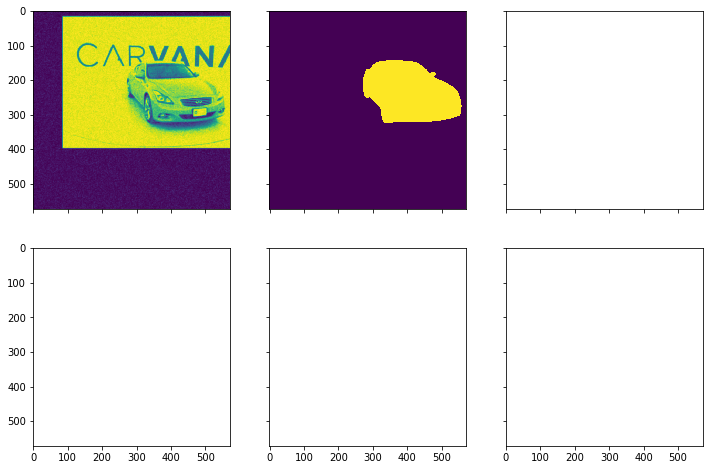

In [9]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
for i in range(ax.shape[0]):
    ax[i, 0].imshow(x_test[i,...,0], aspect="auto")
    ax[i, 1].imshow(y_test[i,...,1], aspect="auto")
    #mask = prediction[i,...,1]
    p = prediction[i,:,:,:];
    mask = np.argmax( p, axis=2 ) 
    ax[i, 2].imshow(mask, aspect="auto")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Ground truth")
ax[0, 2].set_title("Prediction")
fig.tight_layout()
#fig.savefig("cell_problem.png")